In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pickle
import joblib

#preprocess
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# modeling
import lightgbm as lgb
import itertools #grid search用
from sklearn.model_selection import KFold

#metrics
from sklearn.metrics import mean_squared_error

#progress bar
from tqdm.notebook import tqdm

import sys
sys.path.append('../src')
from util import simple_preprocess
from LGBM import lgb_modelling
#plot setting
import myplot
myplot.setting_myplot()

In [2]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows',100)
pd.set_option("display.max_seq_item",150)
pd.set_option("display.width",None)

In [3]:
os.listdir('../features/')

['0.26986_feature.pkl',
 '0.26993_feature.pkl',
 '0.26999_feature.pkl',
 'base.pkl',
 '前面道路の方位区分.pkl',
 '前面道路区分.pkl',
 '形状区分.pkl',
 '所在地コード.pkl',
 '用途区分.pkl',
 '駅名.pkl']

In [4]:
with open('../features/base.pkl', 'rb') as f:
    full = pickle.load(f)

merge_file = ['前面道路の方位区分.pkl','前面道路区分.pkl','形状区分.pkl','所在地コード.pkl','用途区分.pkl','駅名.pkl']
for file in merge_file:
    with open('../features/'+file, 'rb') as f:
        df = pickle.load(f)
        full = pd.concat([full,df],axis=1)

In [6]:
full.columns[:100]

Index(['id', '種類', '地域', '市区町村コード', '地区名', '最寄駅：名称', '最寄駅：距離（分）', '間取り',
       '面積（㎡）', '土地の形状', '間口', '延床面積（㎡）', '建築年', '建物の構造', '用途', '今後の利用目的',
       '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）', '容積率（％）', '取引時点',
       '改装', '取引の事情等', 'y', 'adversarial', '間取り_Ｌ', '間取り_Ｄ', '間取り_Ｋ', '間取り_＋Ｓ',
       '間取り_Ｒ', '間取り_メゾネット', '間取り_オープンフロア', '間取り_スタジオ', '間取り_＋Ｋ',
       '間取り_missing', '間取り_num', '面積（㎡）_2000㎡以上', '土地の形状_rank', '建築年_西暦',
       '建物の構造_木造', '建物の構造_鉄骨造', '建物の構造_ＳＲＣ', '建物の構造_ＲＣ', '建物の構造_missing',
       '建物の構造_ブロック造', '建物の構造_軽量鉄骨造', '取引時点_年', '取引時点_四半期', '取引の事情等_関係者間取引',
       '取引の事情等_その他事情有り', '取引の事情等_他の権利・負担付き', '取引の事情等_missing', '取引の事情等_隣地の購入',
       '取引の事情等_瑕疵有りの可能性', '取引の事情等_調停・競売等', '取引の事情等_私道を含む取引', '用途_その他', '用途_倉庫',
       '用途_店舗', '用途_住宅', '用途_駐車場', '用途_作業場', '用途_工場', '用途_missing', '用途_共同住宅',
       '用途_事務所', '経過年月', '前面道路の方位区分_mean_Ｈ３１価格', '前面道路の方位区分_mean_１平米単価Ｈ３１',
       '前面道路の方位区分_std_Ｈ３１価格', '前面道路の方位区分_std_１平米単価Ｈ３１',
       '前面道路の方位区分_count_Ｈ３１価格', 

In [7]:
use_columns = ['id', '種類', '地域', '市区町村コード', '地区名', '最寄駅：名称', '最寄駅：距離（分）',
       '面積（㎡）', '間口', '延床面積（㎡）', '今後の利用目的',
       '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）', '容積率（％）', '改装',
       'y', 'adversarial', '間取り_Ｌ', '間取り_Ｄ', '間取り_Ｋ', '間取り_＋Ｓ',
       '間取り_Ｒ', '間取り_メゾネット', '間取り_オープンフロア', '間取り_スタジオ', '間取り_＋Ｋ',
       '間取り_missing', '間取り_num', '面積（㎡）_2000㎡以上', '土地の形状_rank', '建築年_西暦',
       '建物の構造_ＳＲＣ', '建物の構造_ブロック造', '建物の構造_軽量鉄骨造', '建物の構造_ＲＣ', '建物の構造_木造',
       '建物の構造_鉄骨造', '建物の構造_missing', '取引時点_年', '取引時点_四半期', '取引の事情等_関係者間取引',
       '取引の事情等_瑕疵有りの可能性', '取引の事情等_その他事情有り', '取引の事情等_他の権利・負担付き',
       '取引の事情等_私道を含む取引', '取引の事情等_隣地の購入', '取引の事情等_missing', '取引の事情等_調停・競売等',
       '用途_工場', '用途_事務所', '用途_住宅', '用途_駐車場', '用途_共同住宅', '用途_店舗', '用途_倉庫',
       '用途_作業場', '用途_missing', '用途_その他','経過年月',
               '前面道路の方位区分_mean_Ｈ３１価格',
       '前面道路の方位区分_mean_１平米単価Ｈ３１', '前面道路の方位区分_std_Ｈ３１価格',
       '前面道路の方位区分_std_１平米単価Ｈ３１',  '前面道路区分_mean_Ｈ３１価格',
       '前面道路区分_mean_１平米単価Ｈ３１', '前面道路区分_std_Ｈ３１価格', '前面道路区分_std_１平米単価Ｈ３１',
        '形状区分_mean_Ｈ３１価格', '形状区分_mean_１平米単価Ｈ３１',
       '形状区分_std_Ｈ３１価格', '形状区分_std_１平米単価Ｈ３１', 
       '所在地コード_mean_Ｈ３１価格', '所在地コード_mean_１平米単価Ｈ３１', '所在地コード_std_Ｈ３１価格',
       '所在地コード_std_１平米単価Ｈ３１', '用途区分_mean_Ｈ３１価格',
       '用途区分_mean_１平米単価Ｈ３１', '用途区分_std_Ｈ３１価格', '用途区分_std_１平米単価Ｈ３１',
        '駅名_mean_Ｈ３１価格', '駅名_mean_１平米単価Ｈ３１',
       '駅名_std_Ｈ３１価格', '駅名_std_１平米単価Ｈ３１', 
       ]
full = full[use_columns]

In [8]:
train = full[full['adversarial']==0]
test = full[full['adversarial']==1]
del full

In [9]:
pp_full,col_ins = simple_preprocess(train,test,"id","y")

object型のユニーク数： 種類 5 地域 5 地区名 1455 最寄駅：名称 657 今後の利用目的 7 前面道路：方位 10 前面道路：種類 15 都市計画 17 改装 3 
----------
shape: (356344, 86)
objects: 9


,種類,地域,地区名,最寄駅：名称,今後の利用目的,前面道路：方位,前面道路：種類,都市計画,改装
0,0,0,1404,628,3,0,0,1,1
1,0,0,1404,628,3,0,0,1,2
2,0,0,1404,628,1,0,0,1,2


floats: 26


,間口,前面道路：幅員（ｍ）,前面道路の方位区分_mean_Ｈ３１価格,前面道路の方位区分_mean_１平米単価Ｈ３１,前面道路の方位区分_std_Ｈ３１価格,前面道路の方位区分_std_１平米単価Ｈ３１,前面道路区分_mean_Ｈ３１価格,前面道路区分_mean_１平米単価Ｈ３１,前面道路区分_std_Ｈ３１価格,前面道路区分_std_１平米単価Ｈ３１,形状区分_mean_Ｈ３１価格,形状区分_mean_１平米単価Ｈ３１,形状区分_std_Ｈ３１価格,形状区分_std_１平米単価Ｈ３１,所在地コード_mean_Ｈ３１価格,所在地コード_mean_１平米単価Ｈ３１,所在地コード_std_Ｈ３１価格,所在地コード_std_１平米単価Ｈ３１,用途区分_mean_Ｈ３１価格,用途区分_mean_１平米単価Ｈ３１,用途区分_std_Ｈ３１価格,用途区分_std_１平米単価Ｈ３１,駅名_mean_Ｈ３１価格,駅名_mean_１平米単価Ｈ３１,駅名_std_Ｈ３１価格,駅名_std_１平米単価Ｈ３１
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.330721e+06,8927.769503,8.022701e+06,8210.925836,3.598947e+06,11641.900715,6.528469e+06,16301.663804,2332500.0,14915.728966,1.241058e+06,5156.935995
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.330721e+06,8927.769503,8.022701e+06,8210.925836,3.598947e+06,11641.900715,6.528469e+06,16301.663804,2332500.0,14915.728966,1.241058e+06,5156.935995
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.330721e+06,8927.769503,8.022701e+06,8210.925836,3.598947e+06,11641.900715,6.528469e+06,16301.663804,2332500.0,14915.728966,1.241058e+06,5156.935995


ints: 38


,市区町村コード,adversarial,間取り_Ｌ,間取り_Ｄ,間取り_Ｋ,間取り_＋Ｓ,間取り_Ｒ,間取り_メゾネット,間取り_オープンフロア,間取り_スタジオ,間取り_＋Ｋ,間取り_missing,面積（㎡）_2000㎡以上,建物の構造_ＳＲＣ,建物の構造_ブロック造,建物の構造_軽量鉄骨造,建物の構造_ＲＣ,建物の構造_木造,建物の構造_鉄骨造,建物の構造_missing,取引の事情等_関係者間取引,取引の事情等_瑕疵有りの可能性,取引の事情等_その他事情有り,取引の事情等_他の権利・負担付き,取引の事情等_私道を含む取引,取引の事情等_隣地の購入,取引の事情等_missing,取引の事情等_調停・競売等,用途_工場,用途_事務所,用途_住宅,用途_駐車場,用途_共同住宅,用途_店舗,用途_倉庫,用途_作業場,用途_missing,用途_その他
0,13101,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,13101,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,13101,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


float to int 11


,最寄駅：距離（分）,面積（㎡）,延床面積（㎡）,建ぺい率（％）,容積率（％）,間取り_num,土地の形状_rank,建築年_西暦,取引時点_年,取引時点_四半期,経過年月
0,1.0,55.0,NaN,80.0,600.0,2.0,9.0,1984.0,2017.0,4.0,33.0
1,5.0,20.0,NaN,80.0,500.0,1.0,9.0,2003.0,2017.0,4.0,14.0
2,3.0,45.0,NaN,80.0,500.0,1.0,9.0,2012.0,2017.0,3.0,5.0


bool型の列数 0
all: 84
int型とfloatだけどint型のユニーク数
市区町村コード 59 adversarial 2 間取り_Ｌ 2 間取り_Ｄ 2 間取り_Ｋ 2 間取り_＋Ｓ 2 間取り_Ｒ 2 間取り_メゾネット 2 間取り_オープンフロア 2 間取り_スタジオ 2 間取り_＋Ｋ 2 間取り_missing 2 面積（㎡）_2000㎡以上 2 建物の構造_ＳＲＣ 2 建物の構造_ブロック造 2 建物の構造_軽量鉄骨造 2 建物の構造_ＲＣ 2 建物の構造_木造 2 建物の構造_鉄骨造 2 建物の構造_missing 2 取引の事情等_関係者間取引 2 取引の事情等_瑕疵有りの可能性 2 取引の事情等_その他事情有り 2 取引の事情等_他の権利・負担付き 2 取引の事情等_私道を含む取引 2 取引の事情等_隣地の購入 2 取引の事情等_missing 2 取引の事情等_調停・競売等 2 用途_工場 2 用途_事務所 2 用途_住宅 2 用途_駐車場 2 用途_共同住宅 2 用途_店舗 2 用途_倉庫 2 用途_作業場 2 用途_missing 2 用途_その他 2 最寄駅：距離（分） 35 面積（㎡） 157 延床面積（㎡） 130 建ぺい率（％） 7 容積率（％） 18 間取り_num 8 土地の形状_rank 10 建築年_西暦 76 取引時点_年 15 取引時点_四半期 4 経過年月 78 

In [10]:
categories = ['市区町村コード','adversarial',
              '間取り_Ｌ','間取り_Ｄ', '間取り_Ｋ', '間取り_＋Ｓ', '間取り_Ｒ', '間取り_メゾネット', '間取り_オープンフロア',
              '間取り_スタジオ', '間取り_＋Ｋ', '間取り_missing',
              '建物の構造_木造', '建物の構造_missing', '建物の構造_鉄骨造', '建物の構造_ＲＣ',
              '建物の構造_ＳＲＣ', '建物の構造_軽量鉄骨造', '建物の構造_ブロック造',
              '取引の事情等_調停・競売等', '取引の事情等_私道を含む取引', '取引の事情等_missing', '取引の事情等_関係者間取引',
              '取引の事情等_その他事情有り', '取引の事情等_他の権利・負担付き',
              '取引の事情等_隣地の購入', '取引の事情等_瑕疵有りの可能性',
              '用途_作業場', '用途_その他', '用途_missing','用途_倉庫', '用途_共同住宅', '用途_店舗', 
              '用途_住宅', '用途_駐車場', '用途_工場', '用途_事務所',
              '面積（㎡）_2000㎡以上'
             ]
for col in categories:
    pp_full[col] = pp_full[col].astype("category")

In [11]:
print(pp_full.select_dtypes('category').columns)
print(pp_full.select_dtypes('int64').columns)
print(pp_full.select_dtypes(float).columns)

train = pp_full[pp_full['adversarial']==0]
test = pp_full[pp_full['adversarial']==1]

Index(['種類', '地域', '市区町村コード', '地区名', '最寄駅：名称', '今後の利用目的', '前面道路：方位', '前面道路：種類',
       '都市計画', '改装', 'adversarial', '間取り_Ｌ', '間取り_Ｄ', '間取り_Ｋ', '間取り_＋Ｓ',
       '間取り_Ｒ', '間取り_メゾネット', '間取り_オープンフロア', '間取り_スタジオ', '間取り_＋Ｋ',
       '間取り_missing', '面積（㎡）_2000㎡以上', '建物の構造_ＳＲＣ', '建物の構造_ブロック造',
       '建物の構造_軽量鉄骨造', '建物の構造_ＲＣ', '建物の構造_木造', '建物の構造_鉄骨造', '建物の構造_missing',
       '取引の事情等_関係者間取引', '取引の事情等_瑕疵有りの可能性', '取引の事情等_その他事情有り',
       '取引の事情等_他の権利・負担付き', '取引の事情等_私道を含む取引', '取引の事情等_隣地の購入', '取引の事情等_missing',
       '取引の事情等_調停・競売等', '用途_工場', '用途_事務所', '用途_住宅', '用途_駐車場', '用途_共同住宅',
       '用途_店舗', '用途_倉庫', '用途_作業場', '用途_missing', '用途_その他'],
      dtype='object')
Index(['id'], dtype='object')
Index(['最寄駅：距離（分）', '面積（㎡）', '間口', '延床面積（㎡）', '前面道路：幅員（ｍ）', '建ぺい率（％）',
       '容積率（％）', 'y', '間取り_num', '土地の形状_rank', '建築年_西暦', '取引時点_年', '取引時点_四半期',
       '経過年月', '前面道路の方位区分_mean_Ｈ３１価格', '前面道路の方位区分_mean_１平米単価Ｈ３１',
       '前面道路の方位区分_std_Ｈ３１価格', '前面道路の方位区分_std_１平米単価Ｈ３１', '前面道路区分_mean_Ｈ３１価格',
       '前面道路区分_mean_

In [12]:
lgb_modelling_params = {
    'alpha': [0.2], 
    'bagging_fraction': [0.9], 
    'bagging_freq': [2], 
    'boosting_type': ['gbdt'], 
    'colsample_bytree': [0.4], 
    'lambda': [0.4], 
    'num_leaves':[2**8-1],
    'learning_rate': [0.01], 
    'metric': ['rmse'], 
    'n_jobs': [-1], 
    'objective': ['regression'], 
    'seed': [2020]}

In [13]:
#NULL_importanceを消す
drop_col = ['adversarial']
train = train.drop(drop_col,axis=1)
test = test.drop(drop_col,axis=1)

In [14]:
predict,score,bst = lgb_modelling(train=train,
                                    test=test,
                                    option_params=lgb_modelling_params,
                                    ID='id',
                                    y='y')

{'alpha': 0.2, 'bagging_fraction': 0.9, 'bagging_freq': 2, 'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'lambda': 0.4, 'learning_rate': 0.01, 'metric': 'rmse', 'n_jobs': -1, 'num_leaves': 255, 'objective': 'regression', 'seed': 2020} 3515
0.26970313906708393

0.26970313906708393 {'alpha': 0.2, 'bagging_fraction': 0.9, 'bagging_freq': 2, 'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'lambda': 0.4, 'learning_rate': 0.01, 'metric': 'rmse', 'n_jobs': -1, 'num_leaves': 255, 'objective': 'regression', 'seed': 2020}


In [15]:
print(bst.params,bst.current_iteration())

{'alpha': 0.2, 'bagging_fraction': 0.9, 'bagging_freq': 2, 'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'lambda': 0.4, 'learning_rate': 0.01, 'metric': 'rmse', 'n_jobs': -1, 'num_leaves': 255, 'objective': 'regression', 'seed': 2020} 3515


In [16]:
fi = pd.DataFrame(bst.feature_importance(importance_type='gain'),index=bst.feature_name())
fi[fi[0] == 0].index.values

array(['間取り_メゾネット', '間取り_スタジオ', '間取り_＋Ｋ'], dtype=object)

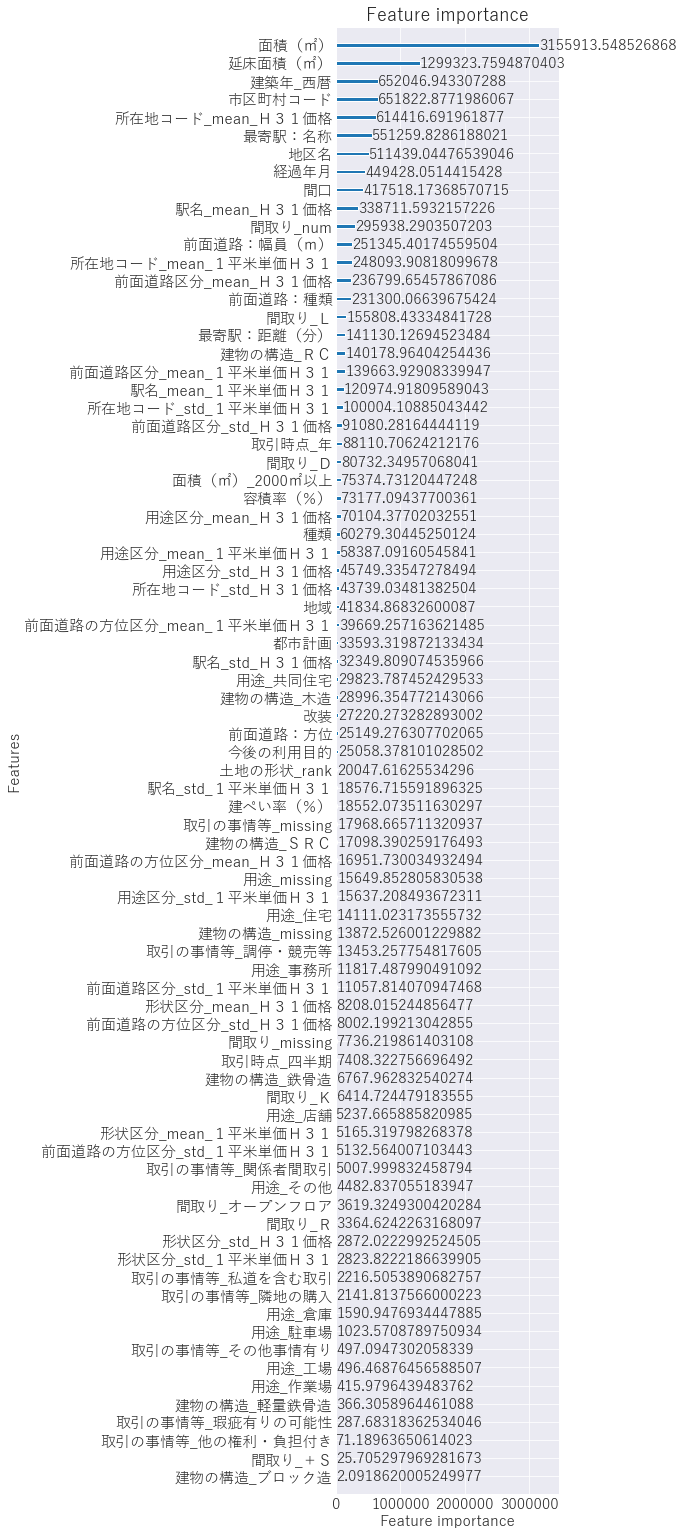

In [17]:
import lightgbm as lgb
lgb.plot_importance(bst,figsize=(4,27),importance_type='gain')
plt.show()

In [18]:
submission = pd.DataFrame(test['id'])
submission['y'] = predict
display(submission.loc[submission['y']<0,'y'])
submission.loc[submission['y']<0,'y'] = 0
display(submission)

390447   -0.066927
391169   -0.111951
Name: y, dtype: float64

,id,y
356344,1,27.856205
356345,2,16.310024
356346,3,231.926457
356347,4,22.892808
356348,5,71.108535
...,...,...
391183,34840,7.081450
391184,34841,2.018524
391185,34842,3.225652
391186,34843,10.059029


In [19]:
submission.to_csv('../submissions/sub_' + str(round(score,5)) + '.csv',index=False)